In [24]:
import numpy as np

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import Aer
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.units import DistanceUnit
from qiskit_nature import settings

from scipy.optimize import minimize

import matplotlib.pyplot as plt

from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

In [25]:
backend = Aer.get_backend("qasm_simulator")

In [65]:
from qiskit_nature.second_q.mappers import ParityMapper

settings.use_pauli_sum_op = False

driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.7348651644548676",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

electronic_structure = driver.run()

hamiltonian = electronic_structure.hamiltonian.second_q_op()

# mapper = JordanWignerMapper()
mapper = ParityMapper(num_particles=electronic_structure.num_particles)
tapered_mapper = electronic_structure.get_tapered_mapper(mapper)


# qubit_op = mapper.map(hamiltonian)
reduced_op = mapper.map(hamiltonian)
tapered_op = tapered_mapper.map(hamiltonian)

hamiltonian_list = []

for pauli, coeff in sorted(tapered_op.label_iter()):
    # print(f"{coeff.real:+.8f} * {pauli}")
    hamiltonian_list.append((pauli, coeff.real))
    
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)
print(hamiltonian)

SparsePauliOp(['I', 'X', 'Z'],
              coeffs=[-1.04106344+0.j, -0.18092368+0.j, -0.79604251+0.j])


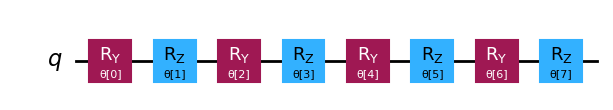

In [66]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
num_params = ansatz.num_parameters

ansatz.decompose().draw("mpl", style="iqp")

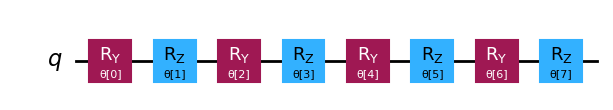

In [67]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [68]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [69]:
x0 = 2 * np.pi * np.random.random(num_params)
x0

array([2.00150077, 2.09826324, 2.08231917, 5.61910119, 1.82714015,
       3.63293561, 5.6568992 , 5.30659108])

In [70]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

Iters. done: 1 [Current cost: -0.5707249145294198]
Iters. done: 2 [Current cost: -0.9979313758393799]
Iters. done: 3 [Current cost: -0.9356168343829958]
Iters. done: 4 [Current cost: -0.3314487187155528]
Iters. done: 5 [Current cost: -0.9790811335498084]
Iters. done: 6 [Current cost: -0.5155296079433389]
Iters. done: 7 [Current cost: -1.4735345969408915]
Iters. done: 8 [Current cost: -1.1322637916021048]
Iters. done: 9 [Current cost: -1.603273035566588]
Iters. done: 10 [Current cost: -1.509594299227706]
Iters. done: 11 [Current cost: -1.6007305648885244]
Iters. done: 12 [Current cost: -1.6203933066979115]
Iters. done: 13 [Current cost: -1.5470893934036807]
Iters. done: 14 [Current cost: -1.599722845352994]
Iters. done: 15 [Current cost: -1.5843342927813628]
Iters. done: 16 [Current cost: -1.5196500455135091]
Iters. done: 17 [Current cost: -1.5897059728877168]
Iters. done: 18 [Current cost: -1.7618239318739088]
Iters. done: 19 [Current cost: -1.8112757609590848]
Iters. done: 20 [Current

In [71]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.8500047257729944
       x: [ 3.053e+00  1.736e+00  1.882e+00  5.604e+00  1.651e+00
            5.270e+00  5.709e+00  6.375e+00]
    nfev: 90
   maxcv: 0.0

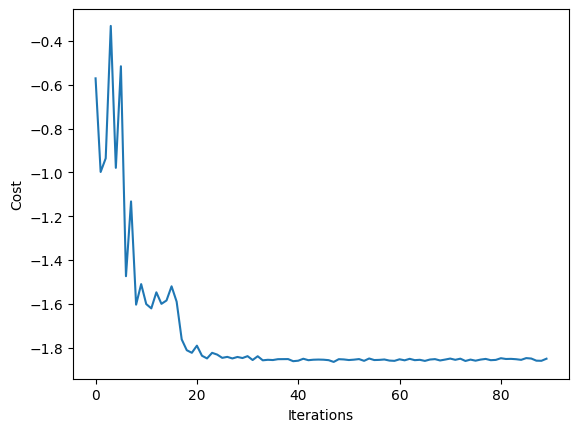

In [72]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()